In [2]:
import tensorflow as tf
import datetime, os
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
import numpy as np
from os.path import exists, join, isfile
from os import listdir
from numpy import *
from keras.utils import to_categorical
import itertools as it
#cut out only dips from samples
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
from os.path import exists, join, isfile
from os import listdir
import pandas as pd

Using TensorFlow backend.


In [9]:
#Load from raw data
#Load dominant class
dataFolders = sorted(listdir('/media/usuario/datos/raw-voltage-dips/'))
print(dataFolders)
numClass = 0
classDips = 1000
nonClassDips = 70
testPercent = 0.8
x_train = []
y_train = []
x_test = []
y_test = []

dataFolders = ['/media/usuario/datos/raw-voltage-dips/' + f for f in dataFolders if exists(join('/media/usuario/datos/raw-voltage-dips/',f))]
#load class of interest
classa = dataFolders[numClass]
# print(classa)
dipsList = [classa + '/' + f for f in listdir(classa) if isfile(join(classa,f))]
# print(len(dipsList))
dipsCounter = 0 
for dip in dipsList:
    with open(dip, 'r') as d:
        if dipsCounter < int(classDips*testPercent):
            x_train.append(loadtxt(dip, usecols = (1,2,3)))
#             x_train.append(loadtxt(dip))
            y_train.append(numClass)
        else:
            x_test.append(loadtxt(dip, usecols = (1,2,3)))
#             x_test.append(loadtxt(dip))
            y_test.append(numClass)
    dipsCounter = dipsCounter + 1
    if dipsCounter >= classDips:
        print('kasa dominujaca: ', dipsCounter)
        break
    
    
#Load rest of the data 
for clas in dataFolders:
    print(clas)
    if clas=='/media/usuario/datos/raw-voltage-dips/0-1k_falla_1f':
        continue
    dipsCounter = 0 
    dipsList = [clas + '/' + f for f in listdir(clas) if isfile(join(clas,f))]
#     print(len(dipsList))
    print('czytam klase: ', clas)
    for dip in dipsList:
        with open(dip, 'r') as d:
            
            if dipsCounter < int(nonClassDips*testPercent):
                x_train.append(loadtxt(dip, usecols = (1,2,3)))
#                 x_train.append(loadtxt(dip))
                y_train.append(numClass+1)
            else:
                x_test.append(loadtxt(dip, usecols = (1,2,3)))
#                 x_test.append(loadtxt(dip))
                y_test.append(numClass+1)
        dipsCounter = dipsCounter + 1
        if dipsCounter >= nonClassDips:
            print(dipsCounter)
            break

['0-1k_falla_1f', '10k-11k_falla_autoextinguible_3f', '11k-12k_arco1_3f', '12k-13k_arco2_3f', '13k-14k_arco3_3f', '14k-15k_arr_3f_equi', '15k-16k_arr_3f_deseq_1', '16k-17k_arr_3f_deseq_2', '17k-18k_arr_3f_equi', '18k-19k_arr_1f', '19k-20k_arr_2f', '1k-2k_falla_1f_2', '2k-3k_falla_1f_3', '3k-4k_falla_2f', '4k-5k_falla_2f_2', '5k-6k_falla_3f_equilibrada', '6k-7k_falla_3f_asimetrica', '7k-8k_falla_3f_simetrica', '8k-9k_falla_autoextinguible_1f', '9k-10k_falla_autoextinguible_2f']
kasa dominujaca:  1000
/media/usuario/datos/raw-voltage-dips/0-1k_falla_1f
/media/usuario/datos/raw-voltage-dips/10k-11k_falla_autoextinguible_3f
czytam klase:  /media/usuario/datos/raw-voltage-dips/10k-11k_falla_autoextinguible_3f
70
/media/usuario/datos/raw-voltage-dips/11k-12k_arco1_3f
czytam klase:  /media/usuario/datos/raw-voltage-dips/11k-12k_arco1_3f
70
/media/usuario/datos/raw-voltage-dips/12k-13k_arco2_3f
czytam klase:  /media/usuario/datos/raw-voltage-dips/12k-13k_arco2_3f
70
/media/usuario/datos/raw-vo

In [10]:
print(x_train[1].shape)

(501, 3)


In [11]:
#cutting time series to 25:300 timesteps
x_train = np.array(x_train)
print(type(x_train))
x_train = x_train[:,25:300,:]
x_test = np.array(x_test)
x_test = x_test[:,25:300,:]
y_train = np.array(y_train)
y_test = np.array(y_test)

#convert to categorical (one-hot vector)
y2_train = to_categorical(y_train, num_classes=2, dtype='float32')
y2_test = to_categorical(y_test, num_classes=2, dtype='float32')

print(x_train[1].shape)

<class 'numpy.ndarray'>
(275, 3)


In [12]:
#check point
print('x_train: shape: ',x_train.shape)
print('x_train: shape of element: ',x_train[399].shape)
print('y_train: shape: ',y_train.shape)
print('y_train labels: ',[(g[0], len(list(g[1]))) for g in it.groupby(list(y_train))])

print('x_test: shape: ',x_test.shape)
print('x_test: shape of element: ',x_test[100].shape)
print('y_test: shape: ',y_test.shape)
print('y_test labels: ',[(g[0], len(list(g[1]))) for g in it.groupby(list(y_test))])


x_train: shape:  (1864, 275, 3)
x_train: shape of element:  (275, 3)
y_train: shape:  (1864,)
y_train labels:  [(0, 800), (1, 1064)]
x_test: shape:  (466, 275, 3)
x_test: shape of element:  (275, 3)
y_test: shape:  (466,)
y_test labels:  [(0, 200), (1, 266)]


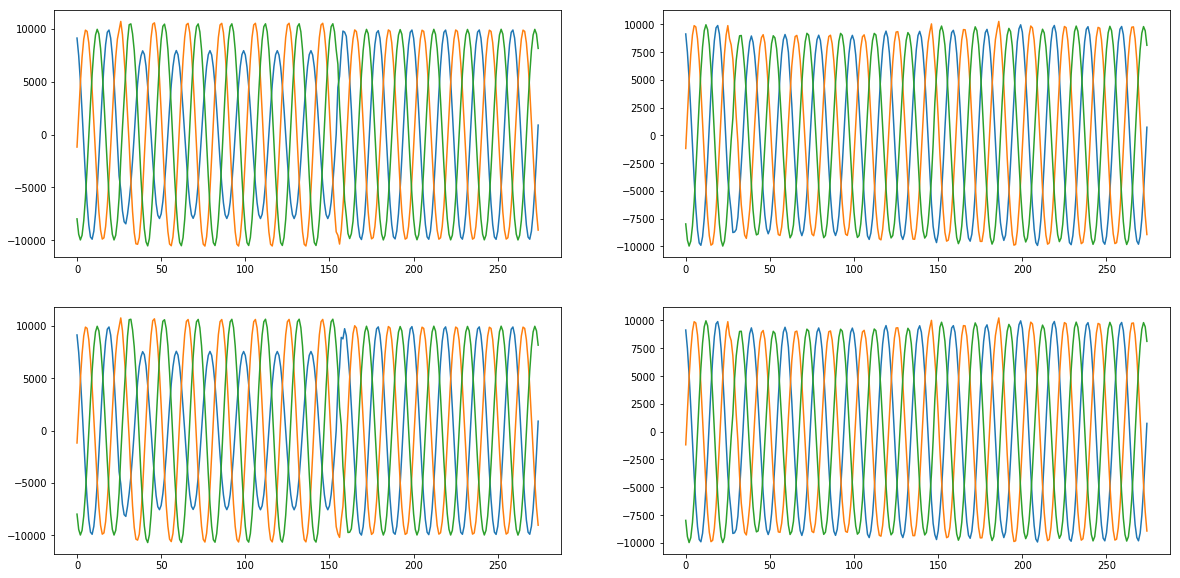

In [14]:
#signal visualization
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(x_train[100])

plt.subplot(2, 2, 2)
plt.plot(x_train[1119])

plt.subplot(2, 2, 3)
plt.plot(x_test[3])

plt.subplot(2, 2, 4)
plt.plot(x_test[279])
plt.savefig('/media/usuario/datos/results/charts/normalization')
plt.show()


In [15]:
#data standarization
from sklearn.preprocessing import StandardScaler
x_train_stand = np.array(x_train) 
x_test_stand = np.array(x_test)
scalers = {}
for i in range(x_train_stand.shape[2]):
    scalers[i] = StandardScaler()
    x_train_stand[:, :, i] = scalers[i].fit_transform(x_train_stand[:, :, i]) 

for i in range(x_test_stand.shape[2]):
    x_test_stand[:, :, i] = scalers[i].transform(x_test_stand[:, :, i]) 

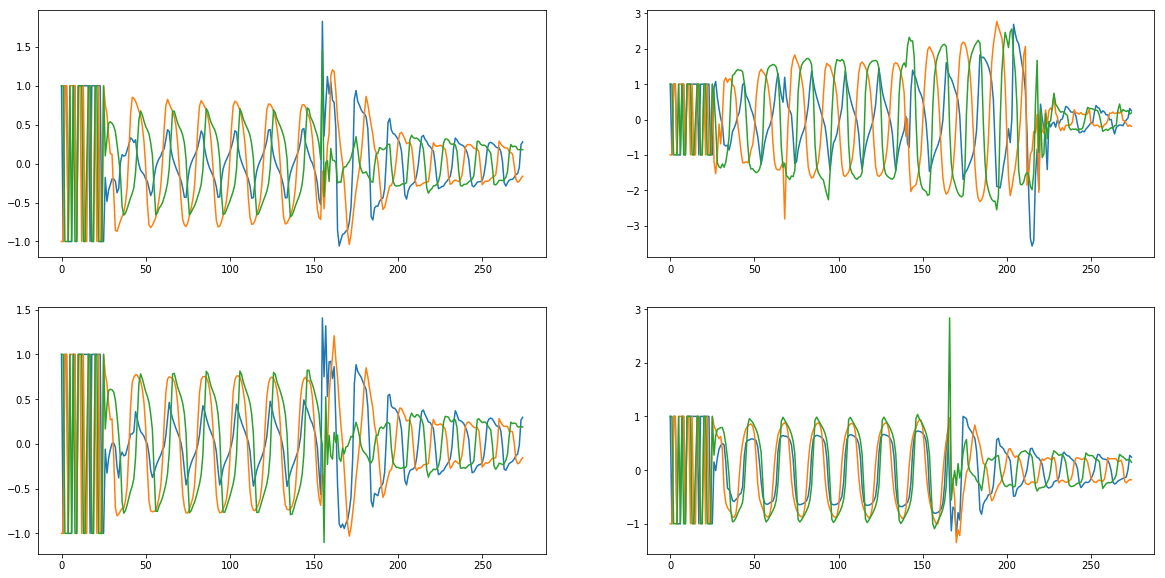

In [16]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(x_train_stand[100])

plt.subplot(2, 2, 2)
plt.plot(x_train_stand[1000])

plt.subplot(2, 2, 3)
plt.plot(x_test_stand[3])

plt.subplot(2, 2, 4)
plt.plot(x_test_stand[100])

plt.show()

In [35]:
#data scaling 
from pandas import Series
# from sklearn.preprocessing import MinMaxScaler

no_dip_path = '/media/usuario/datos/no-dip.txt'
with open(no_dip_path, 'r') as d:
    no_dip = loadtxt(no_dip_path, usecols = (1,2,3))
max_vr = np.amax(no_dip, axis = 0)
min_vr = np.amin(no_dip, axis = 0)
print(max_vr)
print(min_vr)
max_v = 13200/sqrt(3)*sqrt(2)
min_v = -max_v
print(max_v)
print(min_v)
# #scaling 0-1
# x_train_norm = (x_train - min_v) / (max_v - min_v)
# x_test_norm = (x_test - min_v) / (max_v - min_v)
#scaling -0.5 - 0.5
x_train_norm = ((x_train - min_v) / (max_v - min_v))-0.5
x_test_norm = ((x_test - min_v) / (max_v - min_v))-0.5


x_train_norm = np.array(x_train_norm)
x_test_norm = np.array(x_test_norm)


[10239.956 10219.761 10286.015]
[-10239.96 -10219.76 -10286.01]
10777.754868245986
-10777.754868245986


In [36]:
print(x_train_norm[1].shape)

(275, 3)


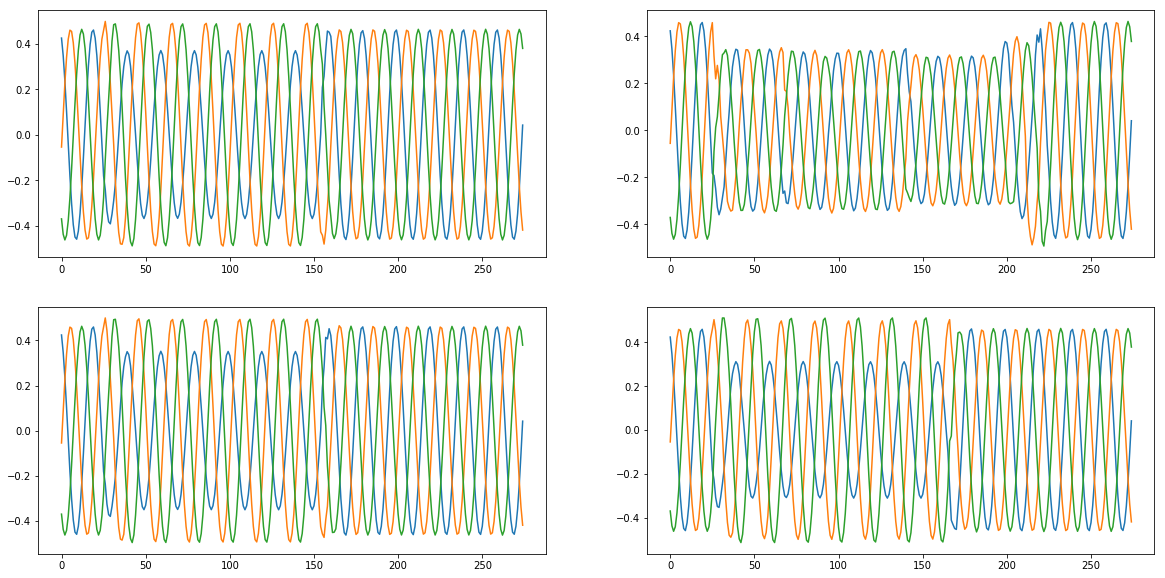

In [37]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(x_train_norm[100])

plt.subplot(2, 2, 2)
plt.plot(x_train_norm[1000])

plt.subplot(2, 2, 3)
plt.plot(x_test_norm[3])

plt.subplot(2, 2, 4)
plt.plot(x_test_norm[100])
plt.savefig('/media/usuario/datos/results/charts/normalization')
plt.show()

In [51]:
#MODEL 1 
model = Sequential()
model.add(LSTM(100, input_shape=x_train[1].shape))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
print('Train...')
# model.fit(x_train,y2_train,validation_data = (x_test,y2_test), epochs = 1000)
history = model.fit(x_train_norm,y2_train, epochs = 400, validation_data = (x_test_norm, y2_test))

Train...
Train on 1160 samples, validate on 290 samples
Epoch 1/400
1160/1160 [==============================] - 34s 29ms/sample - loss: 0.6543 - accuracy: 0.6534 - val_loss: 0.6430 - val_accuracy: 0.6552
Epoch 2/400
1160/1160 [==============================] - 33s 28ms/sample - loss: 0.6460 - accuracy: 0.6552 - val_loss: 0.6425 - val_accuracy: 0.6552
Epoch 3/400
1160/1160 [==============================] - 37s 32ms/sample - loss: 0.6413 - accuracy: 0.6552 - val_loss: 0.6420 - val_accuracy: 0.6552
Epoch 4/400
1160/1160 [==============================] - 36s 31ms/sample - loss: 0.6446 - accuracy: 0.6552 - val_loss: 0.6429 - val_accuracy: 0.6552
Epoch 5/400
1160/1160 [==============================] - 35s 30ms/sample - loss: 0.6491 - accuracy: 0.6552 - val_loss: 0.6418 - val_accuracy: 0.6552
Epoch 6/400
1160/1160 [==============================] - 34s 29ms/sample - loss: 0.6448 - accuracy: 0.6552 - val_loss: 0.6411 - val_accuracy: 0.6552
Epoch 7/400
1160/1160 [===========================

Epoch 110/400
1160/1160 [==============================] - 6s 5ms/sample - loss: 0.6458 - accuracy: 0.6552 - val_loss: 0.6438 - val_accuracy: 0.6552
Epoch 111/400
1160/1160 [==============================] - 6s 5ms/sample - loss: 0.6445 - accuracy: 0.6552 - val_loss: 0.6437 - val_accuracy: 0.6552
Epoch 112/400
1160/1160 [==============================] - 6s 5ms/sample - loss: 0.6462 - accuracy: 0.6552 - val_loss: 0.6437 - val_accuracy: 0.6552
Epoch 113/400
1160/1160 [==============================] - 6s 5ms/sample - loss: 0.6436 - accuracy: 0.6552 - val_loss: 0.6438 - val_accuracy: 0.6552
Epoch 114/400
1160/1160 [==============================] - 6s 5ms/sample - loss: 0.6456 - accuracy: 0.6552 - val_loss: 0.6438 - val_accuracy: 0.6552
Epoch 115/400
1160/1160 [==============================] - 6s 5ms/sample - loss: 0.6448 - accuracy: 0.6552 - val_loss: 0.6436 - val_accuracy: 0.6552
Epoch 116/400
1160/1160 [==============================] - 7s 6ms/sample - loss: 0.6445 - accuracy: 0.6552

Epoch 165/400
1160/1160 [==============================] - 7s 6ms/sample - loss: 0.6482 - accuracy: 0.6552 - val_loss: 0.6444 - val_accuracy: 0.6552
Epoch 166/400
1160/1160 [==============================] - 6s 6ms/sample - loss: 0.6507 - accuracy: 0.6543 - val_loss: 0.6439 - val_accuracy: 0.6552
Epoch 167/400
1160/1160 [==============================] - 6s 5ms/sample - loss: 0.6470 - accuracy: 0.6543 - val_loss: 0.6428 - val_accuracy: 0.6552
Epoch 168/400
1160/1160 [==============================] - 6s 5ms/sample - loss: 0.6432 - accuracy: 0.6560 - val_loss: 0.6468 - val_accuracy: 0.6552
Epoch 169/400
1160/1160 [==============================] - 6s 5ms/sample - loss: 0.6508 - accuracy: 0.6552 - val_loss: 0.6444 - val_accuracy: 0.6552
Epoch 170/400
1160/1160 [==============================] - 6s 5ms/sample - loss: 0.6501 - accuracy: 0.6552 - val_loss: 0.6433 - val_accuracy: 0.6552
Epoch 171/400
1160/1160 [==============================] - 6s 5ms/sample - loss: 0.6450 - accuracy: 0.6552

Epoch 220/400
1160/1160 [==============================] - 34s 30ms/sample - loss: 0.6448 - accuracy: 0.6552 - val_loss: 0.6441 - val_accuracy: 0.6552
Epoch 221/400
1160/1160 [==============================] - 33s 29ms/sample - loss: 0.6437 - accuracy: 0.6552 - val_loss: 0.6439 - val_accuracy: 0.6552
Epoch 222/400
1160/1160 [==============================] - 34s 30ms/sample - loss: 0.6463 - accuracy: 0.6552 - val_loss: 0.6438 - val_accuracy: 0.6552
Epoch 223/400
1160/1160 [==============================] - 35s 30ms/sample - loss: 0.6482 - accuracy: 0.6552 - val_loss: 0.6438 - val_accuracy: 0.6552
Epoch 224/400
1160/1160 [==============================] - 32s 28ms/sample - loss: 0.6476 - accuracy: 0.6552 - val_loss: 0.6439 - val_accuracy: 0.6552
Epoch 225/400
1160/1160 [==============================] - 33s 28ms/sample - loss: 0.6441 - accuracy: 0.6552 - val_loss: 0.6438 - val_accuracy: 0.6552
Epoch 226/400
1160/1160 [==============================] - 32s 28ms/sample - loss: 0.6454 - ac

1160/1160 [==============================] - 33s 28ms/sample - loss: 0.6438 - accuracy: 0.6552 - val_loss: 0.6435 - val_accuracy: 0.6552
Epoch 329/400
1160/1160 [==============================] - 35s 30ms/sample - loss: 0.6436 - accuracy: 0.6552 - val_loss: 0.6430 - val_accuracy: 0.6552
Epoch 330/400
1160/1160 [==============================] - 33s 29ms/sample - loss: 0.6447 - accuracy: 0.6552 - val_loss: 0.6430 - val_accuracy: 0.6552
Epoch 331/400
1160/1160 [==============================] - 33s 29ms/sample - loss: 0.6446 - accuracy: 0.6552 - val_loss: 0.6428 - val_accuracy: 0.6552
Epoch 332/400
1160/1160 [==============================] - 35s 30ms/sample - loss: 0.6450 - accuracy: 0.6552 - val_loss: 0.6456 - val_accuracy: 0.6552
Epoch 333/400
1160/1160 [==============================] - 33s 29ms/sample - loss: 0.6452 - accuracy: 0.6552 - val_loss: 0.6487 - val_accuracy: 0.6552
Epoch 334/400
1160/1160 [==============================] - 33s 28ms/sample - loss: 0.6463 - accuracy: 0.6552

In [53]:
#model evaluation
loss, accuracy = model.evaluate(x_test_norm, y2_test)
print(loss)
print(accuracy)

#predictions
predict_clas= model.predict_classes(x_test_norm)
probab = model.predict(x_test_norm)
for i in range(len(probab)):
    print(probab[i], predict_clas[i], y_test[i])

290/290 [==============================] - 6s 20ms/sample - loss: 0.6406 - accuracy: 0.6552
0.640649283343348
0.6551724
[0.33991238 0.66008765] 1 0
[0.3394688 0.6605312] 1 0
[0.34025887 0.6597412 ] 1 0
[0.34194624 0.65805376] 1 0
[0.34227282 0.6577272 ] 1 0
[0.34215206 0.65784794] 1 0
[0.3382832 0.6617168] 1 0
[0.33678877 0.6632112 ] 1 0
[0.33827853 0.66172147] 1 0
[0.33774415 0.6622558 ] 1 0
[0.34412283 0.65587723] 1 0
[0.3397028  0.66029716] 1 0
[0.3367398 0.6632602] 1 0
[0.33363694 0.6663631 ] 1 0
[0.3368534  0.66314656] 1 0
[0.33777103 0.66222894] 1 0
[0.33648834 0.66351163] 1 0
[0.33752522 0.66247475] 1 0
[0.33621904 0.6637809 ] 1 0
[0.34200135 0.6579987 ] 1 0
[0.33645344 0.6635466 ] 1 0
[0.33945152 0.6605485 ] 1 0
[0.3394047 0.6605953] 1 0
[0.34150997 0.65849006] 1 0
[0.3382977  0.66170233] 1 0
[0.34160668 0.6583933 ] 1 0
[0.3375838  0.66241616] 1 0
[0.34024164 0.6597583 ] 1 0
[0.33903447 0.6609655 ] 1 0
[0.337242 0.662758] 1 0
[0.33879128 0.6612087 ] 1 0
[0.3407023 0.6592977] 1 

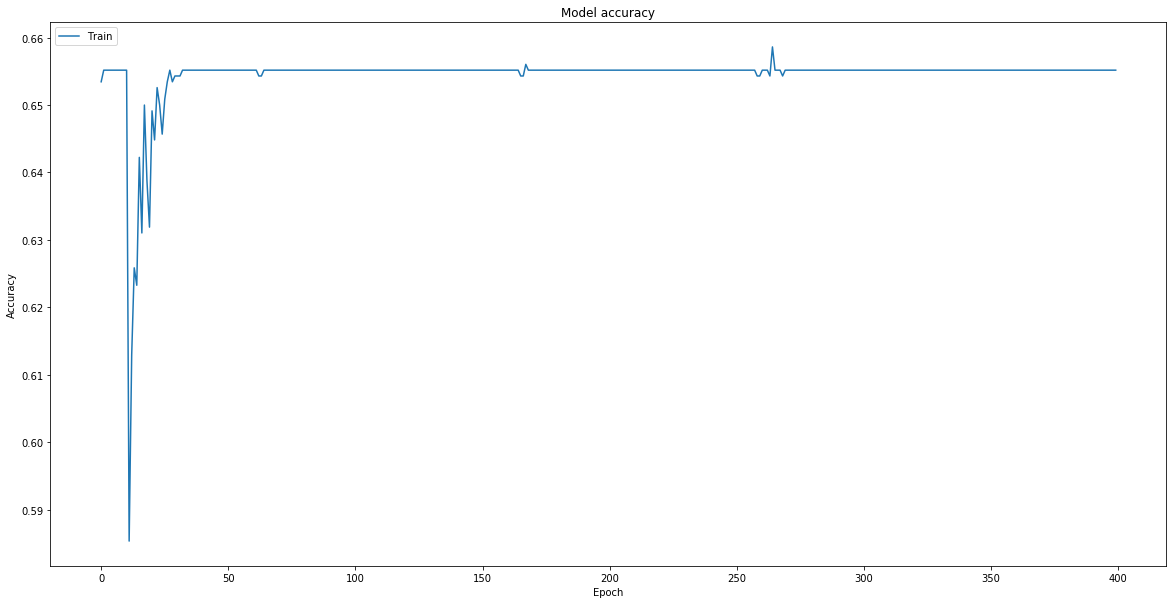

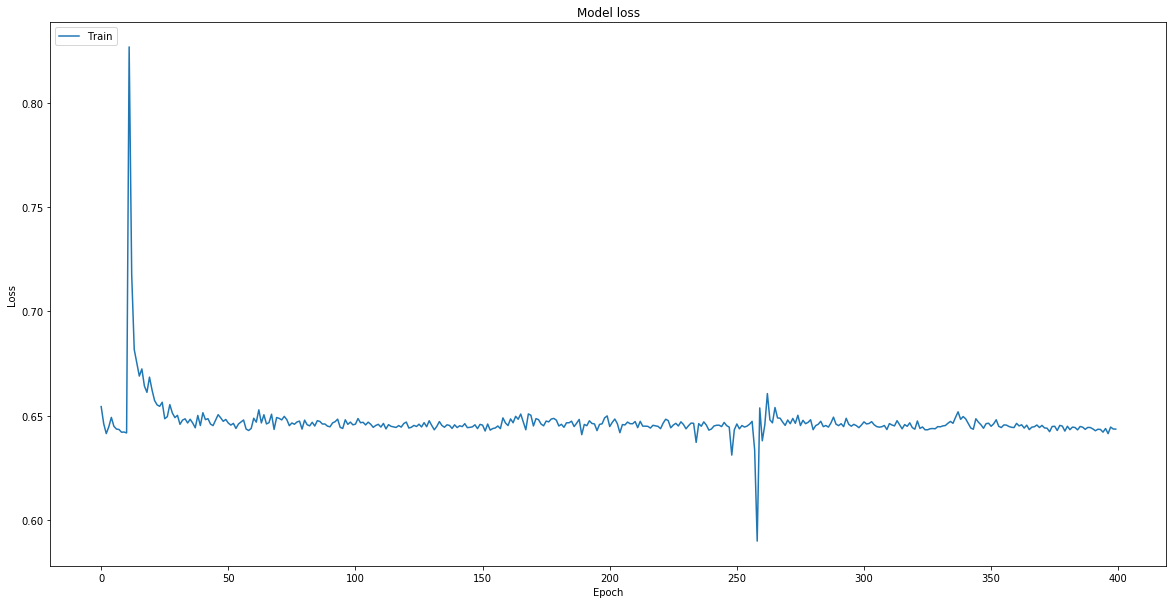

In [54]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(20, 10))

plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
fig = plt.figure(figsize=(20, 10))

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [55]:
# saving whole model
model.save('./lstm_model_3.h5')

In [12]:
del model

In [ ]:
#For repeatability
np.random.seed(10)
tf.set_random_seed(10)

In [40]:
#MODEL 2 
batch_size = 8
epochs = 600
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=x_train[1].shape,kernel_initializer='glorot_uniform'))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# monitor1 = EarlyStopping(monitor = 'val_loss', min_delta = 1e-3, patience = 7, verbose =1, mode='auto', restore_best_weights = True)
# monitor2 = TensorBoard(log_dir="C:\Users\becario_cidisi\logs", histogram_freq=0, write_graph=True, write_images=True)

In [ ]:
history = model.fit(x_train_norm,y2_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test_norm, y2_test))

Train on 1864 samples, validate on 466 samples
Epoch 1/600
1864/1864 [==============================] - 54s 29ms/sample - loss: 0.6347 - accuracy: 0.5917 - val_loss: 0.5154 - val_accuracy: 0.7253
Epoch 2/600
1864/1864 [==============================] - 55s 30ms/sample - loss: 0.5541 - accuracy: 0.6770 - val_loss: 0.5401 - val_accuracy: 0.7039
Epoch 3/600
1864/1864 [==============================] - 55s 29ms/sample - loss: 0.5644 - accuracy: 0.6599 - val_loss: 0.5593 - val_accuracy: 0.6545
Epoch 4/600
1864/1864 [==============================] - 51s 28ms/sample - loss: 0.5639 - accuracy: 0.6754 - val_loss: 0.5339 - val_accuracy: 0.6974
Epoch 5/600
1864/1864 [==============================] - 52s 28ms/sample - loss: 0.5267 - accuracy: 0.7178 - val_loss: 0.4944 - val_accuracy: 0.7425
Epoch 6/600
1864/1864 [==============================] - 54s 29ms/sample - loss: 0.5157 - accuracy: 0.7178 - val_loss: 0.5821 - val_accuracy: 0.6996
Epoch 7/600
1864/1864 [==============================] - 54

1864/1864 [==============================] - 51s 27ms/sample - loss: 0.2853 - accuracy: 0.8868 - val_loss: 0.2467 - val_accuracy: 0.9056
Epoch 110/600
1864/1864 [==============================] - 51s 27ms/sample - loss: 0.2593 - accuracy: 0.8981 - val_loss: 0.2221 - val_accuracy: 0.9120
Epoch 111/600
1864/1864 [==============================] - 52s 28ms/sample - loss: 0.2572 - accuracy: 0.9013 - val_loss: 0.2296 - val_accuracy: 0.9142
Epoch 112/600
1864/1864 [==============================] - 53s 28ms/sample - loss: 0.2470 - accuracy: 0.9034 - val_loss: 0.1836 - val_accuracy: 0.9206
Epoch 113/600
1864/1864 [==============================] - 52s 28ms/sample - loss: 0.2192 - accuracy: 0.9179 - val_loss: 0.2990 - val_accuracy: 0.8991
Epoch 114/600
1864/1864 [==============================] - 51s 28ms/sample - loss: 0.2913 - accuracy: 0.8750 - val_loss: 0.5934 - val_accuracy: 0.5021
Epoch 115/600
1864/1864 [==============================] - 52s 28ms/sample - loss: 0.5715 - accuracy: 0.6679

1864/1864 [==============================] - 54s 29ms/sample - loss: 0.2714 - accuracy: 0.9008 - val_loss: 0.1670 - val_accuracy: 0.9464
Epoch 218/600
1864/1864 [==============================] - 51s 28ms/sample - loss: 0.1715 - accuracy: 0.9426 - val_loss: 0.1721 - val_accuracy: 0.9399
Epoch 219/600
1864/1864 [==============================] - 53s 29ms/sample - loss: 0.1911 - accuracy: 0.9378 - val_loss: 0.1726 - val_accuracy: 0.9378
Epoch 220/600
1864/1864 [==============================] - 55s 29ms/sample - loss: 0.1750 - accuracy: 0.9474 - val_loss: 0.1528 - val_accuracy: 0.9592
Epoch 221/600
1864/1864 [==============================] - 51s 27ms/sample - loss: 0.1924 - accuracy: 0.9345 - val_loss: 0.1555 - val_accuracy: 0.9549
Epoch 222/600
1864/1864 [==============================] - 51s 27ms/sample - loss: 0.1745 - accuracy: 0.9421 - val_loss: 0.1704 - val_accuracy: 0.9399
Epoch 223/600
1864/1864 [==============================] - 55s 29ms/sample - loss: 0.1811 - accuracy: 0.9421

In [25]:
#model evaluation
loss, accuracy = model.evaluate(x_test_norm, y2_test)
print(loss)
print(accuracy)

#predictions
predict_clas= model.predict_classes(x_test_norm)
probab = model.predict(x_test_norm)
for i in range(len(probab)):
    print(probab[i], predict_clas[i], y_test[i])

466/466 [==============================] - 2s 5ms/sample - loss: 0.0245 - accuracy: 0.9893
0.024460825672340748
0.9892704
[0.9595014  0.04049854] 0 0
[9.9987125e-01 1.2877079e-04] 0 0
[9.9985158e-01 1.4834908e-04] 0 0
[9.996891e-01 3.109495e-04] 0 0
[0.98069143 0.01930862] 0 0
[9.9990785e-01 9.2086746e-05] 0 0
[9.99878645e-01 1.21300945e-04] 0 0
[9.9952865e-01 4.7136395e-04] 0 0
[9.9984097e-01 1.5901406e-04] 0 0
[9.9980015e-01 1.9987105e-04] 0 0
[9.9986577e-01 1.3419564e-04] 0 0
[9.9946433e-01 5.3563679e-04] 0 0
[9.9980181e-01 1.9824828e-04] 0 0
[9.9928194e-01 7.1813248e-04] 0 0
[9.9945706e-01 5.4293533e-04] 0 0
[9.999225e-01 7.743059e-05] 0 0
[9.9978513e-01 2.1486417e-04] 0 0
[9.9982184e-01 1.7815302e-04] 0 0
[0.9983109  0.00168907] 0 0
[9.999548e-01 4.516064e-05] 0 0
[9.9980968e-01 1.9033835e-04] 0 0
[9.9984205e-01 1.5791241e-04] 0 0
[0.9984106 0.0015894] 0 0
[9.997938e-01 2.062053e-04] 0 0
[9.9967134e-01 3.2873062e-04] 0 0
[9.9994183e-01 5.8156675e-05] 0 0
[9.9961925e-01 3.8074545e-

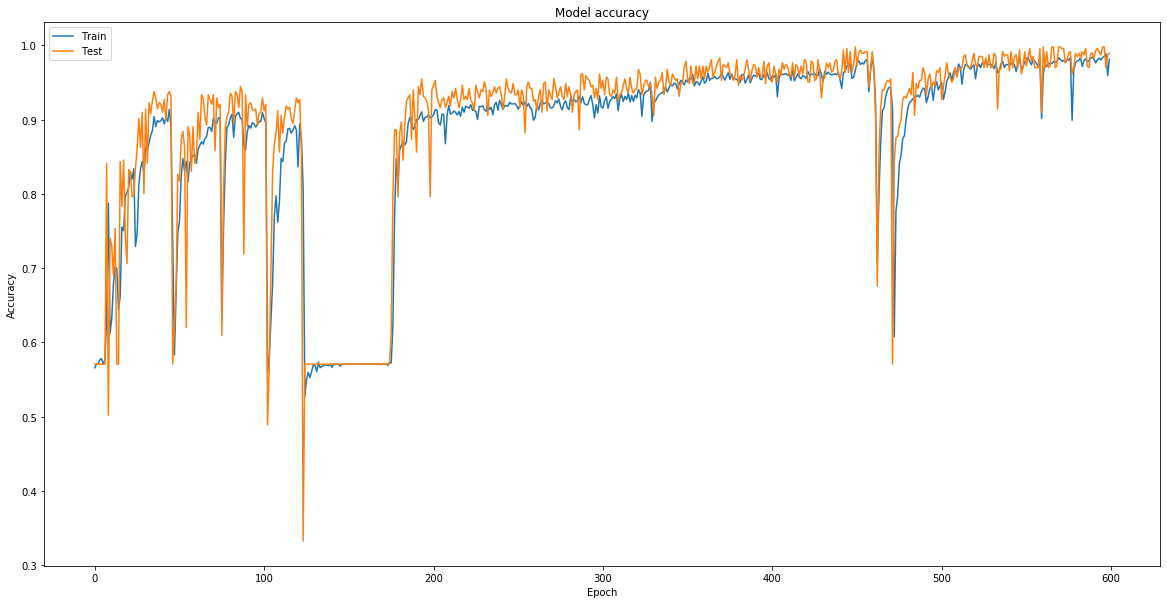

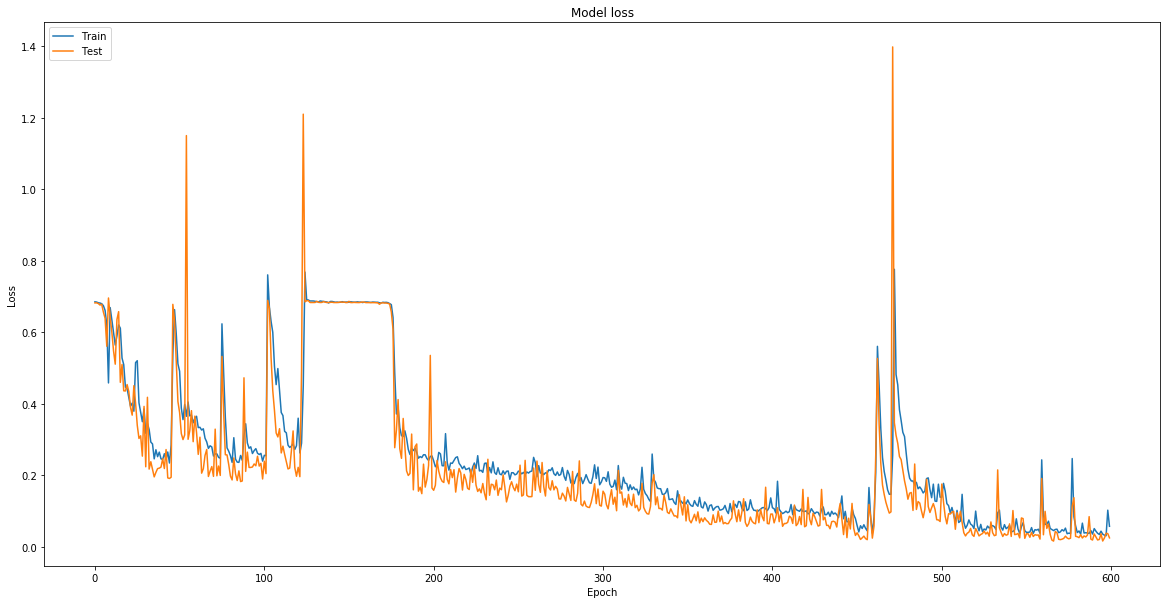

In [26]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(20, 10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
fig = plt.figure(figsize=(20, 10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [27]:
# saving whole model
model.save('./lstm_model_6.h5')